# Assignment 2 - Linear models

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


### Automatic Differentiation!!!

In [ ]:
# sympy let's us do symbolic differentiation (and much more!) in python
import sympy as sp
# we have to define our variables
x = sp.var('x')
# then we can request the derivative or any expression of that variable
pow(2*x,2).diff()

## Linear model in Keras

In [2]:
x = random((30, 2))
y = np.dot(x, [2., 3.]) + 1

### Let's visualize this data

In [ ]:
np.mean(x, 1)
plt.scatter(np.mean(x,1), y)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)
plt.show()

### Model Creation

In [ ]:
# ??Sequential
??Dense
x.shape[1]

In [ ]:
lm = Sequential(layers=[ Dense(1, input_dim=x.shape[1])])
lm.compile(optimizer=Adam(lr=0.1), loss='mse')

In [ ]:
# Evaluate the loss
lm.evaluate(x, y)

In [ ]:
lm.fit(x, y, nb_epoch=100, batch_size=1)

In [ ]:
lm.evaluate(x, y)

In [ ]:
lm.get_weights()

## Training linear model on DogsCats

In [3]:
#path = 'data/dogscats/sample'
path = 'data/dogscats/'
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

In [4]:
batch_size = 100

### Recreating VGG Model

In [5]:
# Import mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.
# We can actually skip this partj
FILES_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)
classes = [class_dict[i][1] for i in class_dict]

In [6]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [7]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [8]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [9]:
model = VGG_16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [10]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

### Let's set up the data

In [11]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [16]:
val_data = get_data(path+'valid', target_size=(224,224))
trn_data = get_data(path+'train', target_size=(244,224))
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [24]:
trn_data.shape

(23000, 3, 224, 224)

Or just load it:

In [ ]:
val_data = load_array(model_path='val_data.bc')
trn_data = load_array(model_path='train_data.bc')

In [22]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [23]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

## Using predictions to create linear model

In [42]:
batch_size = 64

In [41]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

In [47]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

In [55]:
lm = Sequential(layers=[ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [104]:
import sklearn
class Metrics(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        predict = lm.predict(val_features)[:, 0]
        round_predict = np.round(predict)
#         predict = np.asarray()
#         predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = val_labels[:, 0]
#         self.f1s=f1(targ, predict)
        self.f1s = sklearn.metrics.f1_score(targ, round_predict)
        return self.f1s
metrics = Metrics()

In [105]:
import sklearn
# ones = np.ones(10)
# zeros = np.zeros(10)
# sklearn.metrics.f1_score(ones, zeros)
predict = np.asarray(lm.predict(val_features))[:, 0]
targ = val_labels[:, 0]
print(np.round(predict[0:5]))
print(targ[0:5])

[ 1.  1.  0.  1.  1.]
[ 1.  1.  1.  1.  1.]


In [106]:
bach_size = 64
lm.fit(trn_features, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val_features, val_labels), callbacks=[metrics])

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0961 - acc: 0.9690 - val_loss: 0.1032 - val_acc: 0.9610
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0931 - acc: 0.9697 - val_loss: 0.1008 - val_acc: 0.9610
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0906 - acc: 0.9698 - val_loss: 0.0989 - val_acc: 0.9610


In [107]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_17 (Dense)                 (None, 2)             2002        dense_input_14[0][0]             
Total params: 2002
____________________________________________________________________________________________________


In [108]:
metrics.f1s

0.96036585365853666

## Confusion matrix

In [117]:
preds = lm.predict_classes(val_features, batch_size=batch_size)
probs = lm.predict_proba(val_features, batch_size=batch_size)[:, 0]
save_array(model_path+'confusion_predictions.bc', preds)
save_array(model_path+'confusion_probabilites.bc', probs)

1728/2000 [========================>.....] - ETA: 0s

In [116]:
preds = load_array(model_path+'confusion_predictions.bc')
probs = load_array(model_path+'confusion_probabilities.bc')

IOError: [Errno 2] No such file or directory: 'data/dogscats/models/confusion_probabilities.bc/meta/sizes'

In [111]:
filenames = val_batches.filenames

In [ ]:
n_view = 4

In [ ]:
def plots_idx(idx, titles=None):
    images = [image.load_img(path+'valid/'+filenames[i]) for i in idx]
    plots(images, titles=titles)

In [ ]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

In [ ]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
np.where
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

array([False, False, False, ..., False, False, False], dtype=bool)

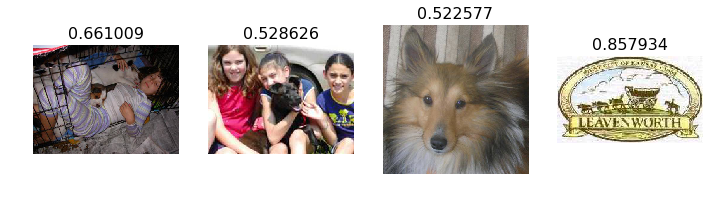

In [133]:
#3. False Negatives
false_neg = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
idx = permutation(false_neg)[:n_view]
plots_idx(idx, probs[idx])


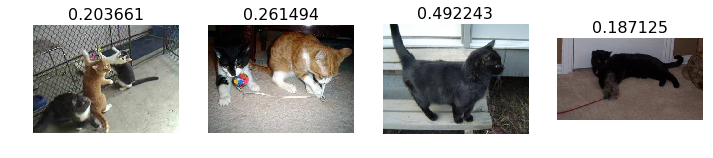

In [134]:
#4. False Positives
false_pos = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
idx = permutation(false_pos)[:n_view]
plots_idx(idx, probs[idx])

In [139]:
cm=confusion_matrix(val_classes, preds)
print(cm)
print(sklearn.metrics.f1_score(val_classes, preds))
print(metrics.f1s)

[[945  55]
 [ 23 977]]
0.961614173228
0.960365853659


In [ ]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Training last layer to output dogs and cats instead

In [ ]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [ ]:
model.summary()

In [143]:
model.pop()

In [154]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [145]:
for layer in model.layers: layer.trainable=False

In [146]:
model.add(Dense(2, activation='softmax'))

In [147]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch,
                        validation_data=val_batches, nb_val_samples=val_batches.N)

In [148]:
opt = Adam(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [155]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
  966/23000 [>.............................] - ETA: 927s - loss: 16.1181 - acc: 0.0000e+00

KeyboardInterrupt: 

In [151]:
model.save_weights(model_path+'finetune1.h5')

In [ ]:
model.load_weights(model_path='finetune1.h5')

In [152]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 49s    


[8.0590477571487433, 0.5]

In [ ]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

In [ ]:
cm = confusion_matrix(val_classes, preds)
print(sklearn.metrics.f1_score(val_classes, preds))

In [ ]:
plot_confusion_matrix(cm, val_batches.class_indices)

### Training all the other layers

In [ ]:
layers = model.layers
first_dense_idx = next(index for layer, index in layers if type(layer) is Dense)
print(first_dense_idx)
# for layer in layers[first_dense_idx:]: layer.trainable=True

In [ ]:
from keras import backend as K
K.set_value(opt.lr, 0.01)

fit_model(model, batches, val_batches, 3)

In [ ]:
model.save_weights(model_path+'finetune2.h5')

In [ ]:
for layer in layers[12:]: layer.Trainable=True
K.set_value(opt.lr, 0.001)

In [ ]:
fit_model(model, batches, val_batches, 4)

In [ ]:
model.save_weights(model_path+'finetune3.h5')

In [ ]:
model.load_weights(model_path+'finetune3.h5')
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.N)